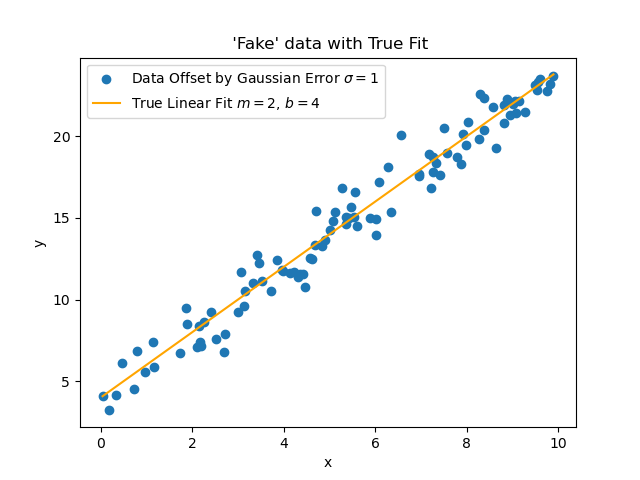

In [11]:
%matplotlib widget

import emcee
import numpy as np
import matplotlib.pyplot as plt

# true model is described by two parameters: m and b
m_true = 2
b_true = 4
N = 100
sigma = 1 # defines the width of the normal distribution from which the errors in y are drawn

#find the true points on the line
x = np.sort(10*np.random.rand(N)) # random x values between 0 and 10
y = m_true*x + b_true # true y values for each x
y_error = np.random.normal(loc=0, scale=sigma, size = N) # draw vector of N points from normal distribution with width sigma
y_new = y + y_error

plt.scatter(x, y_new,label='Data Offset by Gaussian Error $\sigma=$' + str(sigma))
plt.plot(x,y,"orange",label='True Linear Fit $m=$' + str(m_true) + ', $b=$' + str(b_true)) #true model
plt.xlabel('x')
plt.ylabel('y')
plt.title(' \'Fake\' data with True Fit')
plt.legend()


Mean autocorrelation time: 28.662 steps


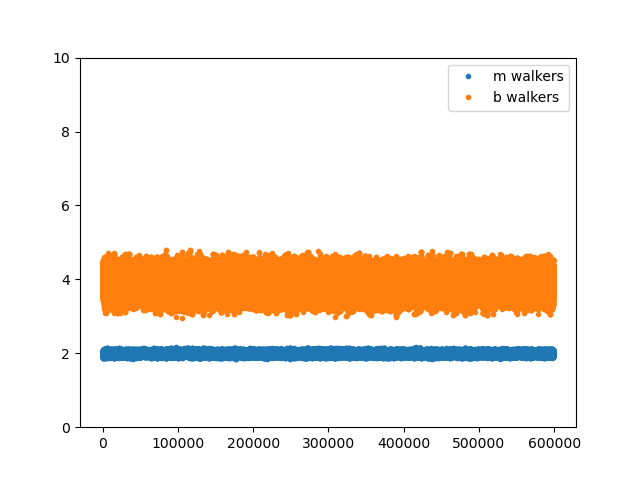

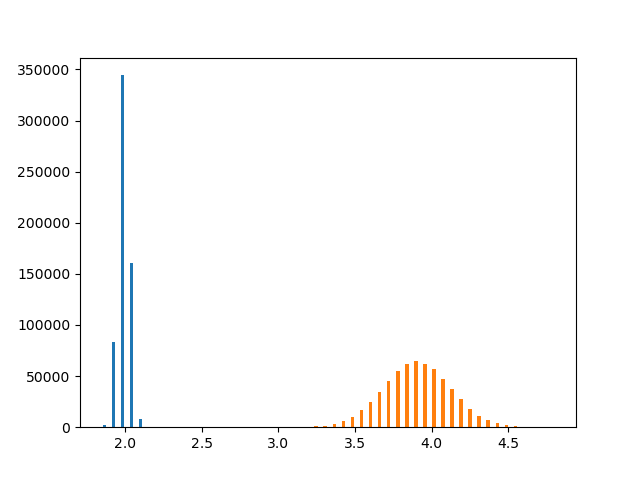

In [12]:
import scipy.stats as sts
import math
from numpy import *

def model(x,m,b):
    model = m*x + b
    return model

def lnprior(params):
    m, b = params
    if m <= 0:
        return -inf
    elif b <= 0:
        return -inf
    return 0

def lnlike(params,x,y_new):
    m, b = params
    y_val = model(x,m,b) # return y
    return sum(sts.norm.logpdf(y_new, loc=y_val, scale=sigma)) # arbitrary width of normal dist?—no, we can use sigma since in reality we would be able to estimate the error size

def lnprob(params,x,y_new): #i.e. the posterior
    lp = lnprior(params)
    if not isfinite(lp):
        return -inf
    return lp + lnlike(params,x,y_new)

Nwalker = 20
Ndim = 2
burn_in = 1200

p0 = 10*np.random.rand(Nwalker, Ndim)  # random starting guess
sampler = emcee.EnsembleSampler(Nwalker, Ndim, lnprob, args=(x,y_new)) #
sampler.run_mcmc(p0, 30000)


print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

plt.figure()
samples = sampler.get_chain(flat=True)
samples = samples[burn_in:len(samples)]

plt.plot(samples[:,0], '.', label='m walkers')
plt.plot(samples[:,1], '.', label='b walkers')
plt.legend()
plt.ylim([0, 10])
plt.show()

plt.figure()
plt.hist(samples, bins=50)
plt.show()

2.0026528093057068
3.891716199858587


array([2.00280962, 3.89101792])

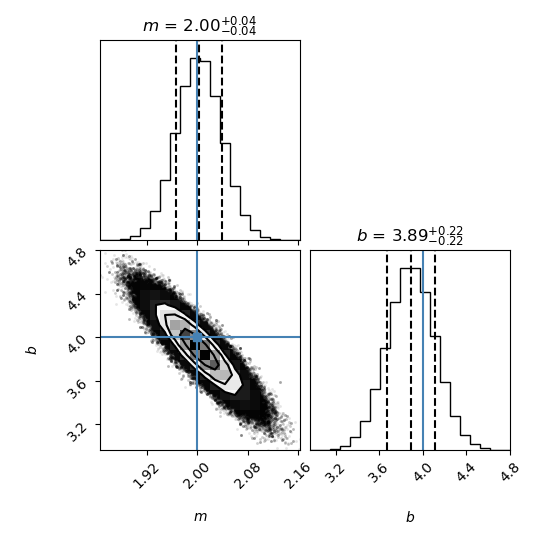

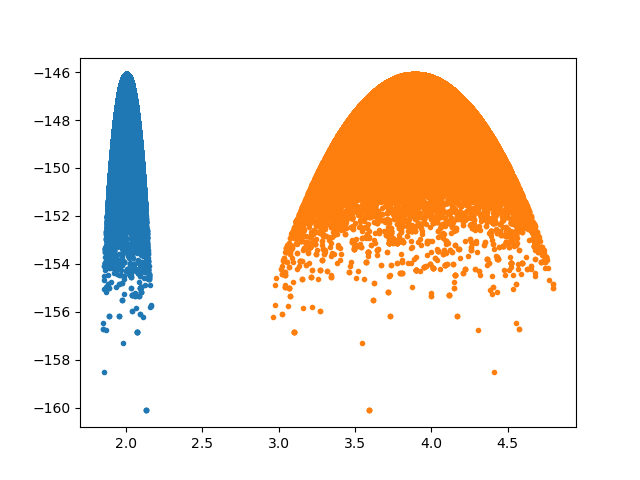

In [13]:
import corner
import emcee as mc

corner.corner(samples,labels=['$m$','$b$'],quantiles=[0.16,0.5,0.84],show_titles=True,truths=[m_true,b_true])
corner.quantile(samples,[0.16,0.50,0.84])

print(mean(samples[:,0]))
print(mean(samples[:,1]))

probs = sampler.get_log_prob(flat=True)
probs = probs[burn_in:len(probs)]

plt.figure()
plt.plot(samples,probs,'.')
n = np.argmax(probs)
probs[n]
samples[n] # sample with highest likelihood

In [14]:
A = np.vstack((np.ones_like(x), x)).T
C = np.diag(sigma*np.ones(100) * sigma*np.ones(100))
cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y_new)))
print('Least squares fitting result:')
print('slope: {0:1.5f}'.format(m_ls))
print('y-intercept: {0:1.5f}'.format(b_ls))


Least squares fitting result:
slope: 2.00278
y-intercept: 3.89114
